In [1]:
import pandas as pd 
from sklearn.feature_selection import VarianceThreshold , SelectKBest , f_classif
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import math
import itertools
from amogel.utils.ac import generate_ac_feature_selection
import warnings
warnings.filterwarnings("ignore")

In [2]:
# data preparation 
# download data from google drive 
# !gdown --id 1tXtQwLBqoI6sjV6QTXR1Dbw_6MTexjez

# unzip the data and delete the zip file
# !unzip -q xena_ggi_ppi_co.zip

In [2]:
# load omic data 
def load_omic_data(omic_file):
    omic_data = pd.read_csv(omic_file, sep="\t", index_col=0)
    return omic_data


def filtering_variance(df: pd.DataFrame , threshold:float): 
        
    default_shape = df.shape
    
    sel = VarianceThreshold(threshold=threshold)
    df_filtered  = pd.DataFrame(sel.fit_transform(df) , index=df.index , columns=df.columns[sel.get_support()])
    
    filter_shape = df_filtered.shape
    print(f"Variance filtering | Default shape: {default_shape} | Filtered shape: {filter_shape}")
    
    return df_filtered

def annovaf_filtering( df: pd.DataFrame , df_label: pd.DataFrame , target: str , threshold: float)->pd.DataFrame:
        
        assert isinstance(df , pd.DataFrame) , "Invalid input"
        assert isinstance(df_label , pd.DataFrame) , "Invalid input"
        assert target in df_label.columns , f"Invalid target column name, not found in the label dataframe | {df_label.columns.tolist()}"
        
        default_shape = df.shape
        
        df_merged = pd.concat([df , df_label[target]] , axis=1)
        df_merged_mean = df_merged.groupby(target).mean()
        combination = list(itertools.permutations(df_merged_mean.index , 2))
        selected_genes = []
        for idx , gene in enumerate(df_merged.columns[:-1]): 
            # calculate fold-change for each gene to different groups
            # generate possible groups 
            try:
                fold_change = [
                    math.log2(df_merged_mean.loc[group1,gene]/df_merged_mean.loc[group2 , gene]) for group1 , group2 in combination
                ]
                
                # check if the fold change is greater than the threshold
                if any(x > 1 for x in fold_change):
                    selected_genes.append(gene)
            except Exception as e:
                pass
                #selected_genes.append(gene)
            
        print(f"Selected genes: {len(selected_genes)} , {selected_genes[:5]}...")
        if len(selected_genes) > 10:
            df = df[selected_genes]
            
        sel = SelectKBest(score_func=f_classif, k=threshold)
        df_filtered = pd.DataFrame(sel.fit_transform(df, df_label[target]), index=df.index , columns=df.columns[sel.get_support()])
        
        filter_shape = df_filtered.shape
        print(f"ANOVA-F filtering | Default shape: {default_shape} | Filtered shape: {filter_shape}")
        
        return  df_filtered

In [3]:
# load STRING database
string_link = pd.read_csv("9606.protein.links.detailed.v12.0.txt", sep="\s", engine="python")
string_info = pd.read_csv("9606.protein.info.v12.0.txt", sep="\t")

# load GGI database 
GGI = pd.read_csv("ggi.txt", sep="\t")

# preprocess 
ppi_df = pd.merge(string_link , string_info[["#string_protein_id", "preferred_name"]], left_on="protein1", right_on="#string_protein_id")
ppi_df.rename(columns={"preferred_name":"protein1_name"}, inplace=True)
ppi_df = pd.merge(ppi_df , string_info[["#string_protein_id", "preferred_name"]], left_on="protein2", right_on="#string_protein_id")
ppi_df.rename(columns={"preferred_name":"protein2_name"}, inplace=True)
ppi_df = ppi_df[["protein1_name", "protein2_name", "neighborhood" , "coexpression"]]

# load omic
cnv = load_omic_data("cnv.txt")
cnv.index = cnv.index.str.split("|").str[0]
cnv.columns = ["-".join(col.split("-")[0:3]) for col in cnv.columns]
cnv = cnv.T
cnv.index.name = "sample"

mRNA = load_omic_data("mRNA.txt")
mRNA.columns = ["-".join(col.split("-")[0:3]) for col in mRNA.columns]
mRNA = mRNA.T
mRNA.index.name = "sample"

# load label 
label  = pd.read_csv("TCGAbiolinks.csv")
label = label[["patient","BRCA_Subtype_PAM50"]]
label.set_index("patient", inplace=True)
label.columns = ["class"]
label.index.name = "sample"

# check missing value 
print("cnv missing value: ", cnv.isnull().sum().sum())
print("mRNA missing value: ", mRNA.isnull().sum().sum())
print("label missing value: ", label.isnull().sum().sum())

label = label.dropna()

common_samples = set(cnv.index) & set(mRNA.index) & set(label.index)

# filter data
cnv = cnv.loc[list(common_samples)]
mRNA = mRNA.loc[list(common_samples)]
label = label.loc[list(common_samples)]

# merge duplicated index with mean 
mRNA = mRNA.groupby(mRNA.index).mean()

# sort index
cnv.sort_index(inplace=True)
mRNA.sort_index(inplace=True)
label.sort_index(inplace=True)

label_enc = OrdinalEncoder()
label["class"] = label_enc.fit_transform(label[["class"]])
label_enc.categories_

cnv missing value:  0
mRNA missing value:  0
label missing value:  2


In [58]:
cnv_filter = filtering_variance(cnv, 0.01)
mrna_filter = filtering_variance(mRNA, 0.01)
cnv_filter = annovaf_filtering(cnv_filter, label, "class", 1000)
mrna_filter = annovaf_filtering(mrna_filter, label, "class", 1000)

# scale data
cnv_filter = cnv_filter / cnv_filter.max().max()
mrna_filter = mrna_filter / mrna_filter.max().max()

In [59]:
# data splitting
X_train, X_test, _ , _ = train_test_split(label.index, label["class"], test_size=0.3, random_state=42)

cnv_train = cnv_filter.loc[X_train]
cnv_test = cnv_filter.loc[X_test]
mrna_train = mrna_filter.loc[X_train]
mrna_test = mrna_filter.loc[X_test]
label_train = label.loc[X_train]
label_test = label.loc[X_test]

In [61]:
from amogel.utils.ac import generate_ac_feature_selection
# merged cnv_train and mrna_train
train_data = pd.concat([mrna_train, cnv_train], axis=1)
test_data = pd.concat([mrna_test, cnv_test], axis=1)

train_columns = train_data.columns.tolist()
test_columns = test_data.columns.tolist()   

train_data.columns = [ i for i in range(len(train_columns))]
test_data.columns = [ i for i in range(len(test_columns))]

train_data.index = [ i for i in range(train_data.shape[0])]
test_data.index = [ i for i in range(test_data.shape[0])]
label_train.index = [ i for i in range(label_train.shape[0])]
label_test.index = [ i for i in range(label_test.shape[0])]

est , selected_gene , information_edge_tensor  = generate_ac_feature_selection(train_data.copy(deep=True) , label_train.copy(deep=True) , "" , n_bins=3 , df_test_data=test_data.copy(deep=True) , df_test_label=label_test.copy(deep=True) , fixed_k=1000)

















Generate CARs for class 4.0: 100%|██████████| 5/5 [00:51<00:00, 10.34s/it]


------ ARM summary [Gene Filter: 0]---------
    data_shape  itemset_length  support  support_percentage  cars_length  \
0  (125, 2000)            1689      117           93.600000         1689   
1   (56, 2000)            1673       42           75.000000         1673   
2  (391, 2000)            1212      341           87.212276         1212   
3  (144, 2000)            1184      117           81.250000         1184   
4   (30, 2000)            1562       23           76.666667         1562   

   avg_confidence  
0        0.773139  
1        0.221298  
2        0.542169  
3        0.261024  
4        0.236975  
Top 1000 | 0.5268 | Lens gene: 831























































































































































































































































Generate information-edge tensor: 100%|██████████| 5000/5000 [01:19<00:00, 62.76it/s]

Best K: 1000 | Best Acc: 0.5268


In [63]:
selected_gene = sorted(selected_gene)
selection = {0:0,1:0}
for gene in selected_gene: 
    if gene in range(0 , cnv_train.shape[1]):
        selection[0] += 1
    else:
        selection[1] += 1
print(f"Selected gene distribution: {selection}")

Selected gene distribution: {0: 278, 1: 553}


In [64]:
# generate prior information edges
import torch
gene_df = pd.DataFrame({"gene_name":train_columns, "gene_idx": range(len(train_columns))})
merged = pd.merge(ppi_df , gene_df, left_on="protein1_name", right_on="gene_name")
merged.rename(columns={"gene_idx":"gene1_idx"}, inplace=True)
merged = pd.merge(merged , gene_df, left_on="protein2_name", right_on="gene_name")
merged.rename(columns={"gene_idx":"gene2_idx"}, inplace=True)

ppi_tensor = torch.zeros((len(train_columns), len(train_columns)))
ppi_tensor[merged["gene1_idx"].values , merged['gene2_idx'].values] = torch.tensor(merged['neighborhood'] , dtype=torch.float)
ppi_tensor[merged["gene2_idx"].values , merged['gene1_idx'].values] = torch.tensor(merged['neighborhood'] , dtype=torch.float)

co_tensor = torch.zeros((len(train_columns), len(train_columns)))
co_tensor[merged["gene1_idx"].values , merged['gene2_idx'].values] = torch.tensor(merged['coexpression'] , dtype=torch.float)
co_tensor[merged["gene2_idx"].values , merged['gene1_idx'].values] = torch.tensor(merged['coexpression'] , dtype=torch.float)

ggi = GGI[["Official Symbol Interactor A", "Official Symbol Interactor B"]]
ggi.rename(columns={"Official Symbol Interactor A":"gene1_name", "Official Symbol Interactor B":"gene2_name"}, inplace=True)
ggi = pd.merge(ggi , gene_df, left_on="gene1_name", right_on="gene_name")
ggi.rename(columns={"gene_idx":"gene1_idx"}, inplace=True)
ggi = pd.merge(ggi , gene_df, left_on="gene2_name", right_on="gene_name")
ggi.rename(columns={"gene_idx":"gene2_idx"}, inplace=True)

ggi_tensor = torch.zeros((len(train_columns), len(train_columns)))
ggi_tensor[ggi["gene1_idx"].values , ggi['gene2_idx'].values] = 1
ggi_tensor[ggi["gene2_idx"].values , ggi['gene1_idx'].values] = 1

# print all information shape 
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Train label shape: {label_train.shape}")
print(f"Test label shape: {label_test.shape}")
print(f"AC information shape: {information_edge_tensor.shape}")
print(f"PPI information shape: {ppi_tensor.shape}")
print(f"CO information shape: {co_tensor.shape}")
print(f"GGI information shape: {ggi_tensor.shape}")

In [82]:
# create unified edges matrix 
general_edges = []
info_edge = information_edge_tensor[selected_gene][:,selected_gene]
info_edge[torch.isnan(info_edge)] = 0
info_edge[ info_edge < 0.2 ] = 0
# filter 

mean_info_edge = info_edge.mean()

# scale info_edge to 0-1
info_edge = (info_edge - info_edge.min())/(info_edge.max()-info_edge.min())

ppi_edge = ppi_tensor[selected_gene][: , selected_gene]
#ppi_edge = (ppi_edge - ppi_edge.min())/(ppi_edge.max()-ppi_edge.min())
ppi_edge = ppi_edge*mean_info_edge


co_edge = co_tensor[selected_gene][: , selected_gene]
#co_edge = (co_edge - co_edge.min())/(co_edge.max()-co_edge.min())
co_edge = co_edge*mean_info_edge

ggi_edge = ggi_tensor[selected_gene][: , selected_gene]*mean_info_edge

general_edges = torch.stack([info_edge , ppi_edge , co_edge , ggi_edge] , dim=-1)
print(f"General edges shape: {general_edges.shape}")

General edges shape: torch.Size([831, 831, 4])


(array([6.90041e+05, 2.06000e+02, 2.30000e+02, 4.40000e+01, 3.60000e+01,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([0.        , 0.02134025, 0.0426805 , 0.06402075, 0.085361  ,
        0.10670125, 0.12804149, 0.14938174, 0.17072199, 0.19206224,
        0.21340249]),
 <BarContainer object of 10 artists>)

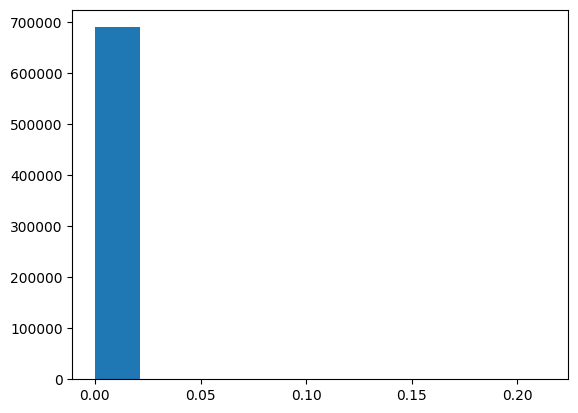

In [83]:
import matplotlib.pyplot as plt

plt.hist(ppi_edge.flatten().numpy())

In [84]:
from tqdm import tqdm 
from torch.nn.functional import one_hot 
from amogel.utils.common import symmetric_matrix_to_pyg

train_transformed = pd.DataFrame(est.transform(train_data)).iloc[: , selected_gene]
train_graphs = []
with tqdm(total=train_data.shape[0] , desc="Generating training graphs") as pbar: 
    for idx, sample in train_transformed.iterrows():
        torch_sample = torch.tensor(sample.values , dtype=torch.float32).unsqueeze(-1)
        torch_sample = one_hot(torch_sample.long() , num_classes=3).squeeze(1).float() 
        graph = symmetric_matrix_to_pyg(
            matrix = general_edges ,
            node_features=torch_sample, 
            y=torch.tensor(label_train.loc[idx].values , dtype=torch.long), 
            edge_threshold=0.0
        )
        
        train_graphs.append(graph)
        pbar.update(1)
        
test_transformed = pd.DataFrame(est.transform(test_data)).iloc[: , selected_gene]
test_graphs = []
with tqdm(total=test_data.shape[0] , desc="Generating test graphs") as pbar: 
    for idx, sample in test_transformed.iterrows():
        torch_sample = torch.tensor(sample.values , dtype=torch.float32).unsqueeze(-1)
        torch_sample = one_hot(torch_sample.long() , num_classes=3).squeeze(1).float() 
        graph = symmetric_matrix_to_pyg(
            matrix = general_edges ,
            node_features=torch_sample, 
            y=torch.tensor(label_test.loc[idx].values , dtype=torch.long), 
            edge_threshold=0.0
        )
        
        test_graphs.append(graph)
        pbar.update(1)

























































































































































































Generating training graphs: 100%|██████████| 746/746 [00:19<00:00, 37.71it/s]















































































Generating test graphs: 100%|██████████| 320/320 [00:08<00:00, 38.27it/s]


In [87]:
print(f"Node dimension: {test_graphs[0].x.shape} , \nEdge dimension: {test_graphs[0].edge_index.shape} , \
        \nEdge attribute dimension: {test_graphs[0].edge_attr.shape} , \
        \nEdge max: {test_graphs[0].edge_attr.max(dim=0).values} , \
        \nEdge mean: {test_graphs[0].edge_attr.mean(dim=0)} , \
        \nNonzero edge: {torch.count_nonzero(test_graphs[0].edge_attr , dim=0)}")

Node dimension: torch.Size([831, 3]) , 
Edge dimension: torch.Size([2, 2600]) ,         
Edge attribute dimension: torch.Size([2600, 4]) ,         
Edge max: tensor([1.0000e+00, 5.0810e-02, 7.1966e-01, 9.2382e-04]) ,         
Edge mean: tensor([6.0107e-01, 3.9085e-05, 8.0067e-03, 1.7766e-05]) ,         
Nonzero edge: tensor([2600,    2,  184,   50])


In [86]:
# model training
from torch_geometric.loader import DataLoader
from amogel.model.GCN import GCN
import mlflow
from pytorch_lightning import Trainer

mlflow.pytorch.autolog()
mlflow.set_experiment("MPKGNN")
        
train_loader = DataLoader(train_graphs , batch_size=50 , shuffle=True)
test_loader = DataLoader(test_graphs , batch_size=50 , shuffle=False)

model = GCN(
    in_channels=train_graphs[0].x.shape[1],
    hidden_channels=32,
    num_classes=5, 
    lr=0.00005,
    drop_out=0.05, 
    pooling_ratio=0.0,
    decay=0.01, 
    no_of_nodes=train_graphs[0].x.shape[0] * train_graphs[0].x.shape[1], 
    DNN=True , 
    GNN=True , 
    save_dir="."
)

with mlflow.start_run():
    #mlflow.log_params(self.config.__dict__)
    mlflow.log_params({
        "node_dim": train_graphs[0].x.shape, 
        "edge_dim": train_graphs[0].edge_index.shape,
        "edge_attr_dim": train_graphs[0].edge_attr.shape,
        #"edge_attr_max": train_graph[0].edge_attr.max(dim=0).values,
        "nonzero_edge": torch.count_nonzero(train_graphs[0].edge_attr , dim=0),
        "edge_attr_mean": train_graphs[0].edge_attr.mean(dim=0)
    })
    mlflow.log_param("dataset" , "mpkgnn_brca")
    trainer = Trainer(max_epochs=500)
    trainer.fit(model , train_loader , test_loader)

2024/08/27 22:21:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
INFO: GPU available: True (cuda), used: True


[2024-08-27 22:21:32,566: INFO: setup: GPU available: True (cuda), used: True]


INFO: TPU available: False, using: 0 TPU cores


[2024-08-27 22:21:32,567: INFO: setup: TPU available: False, using: 0 TPU cores]


INFO: IPU available: False, using: 0 IPUs


[2024-08-27 22:21:32,568: INFO: setup: IPU available: False, using: 0 IPUs]


INFO: HPU available: False, using: 0 HPUs


[2024-08-27 22:21:32,569: INFO: setup: HPU available: False, using: 0 HPUs]
[2024-08-27 22:21:32,584: INFO: cuda: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]]
[2024-08-27 22:21:32,588: INFO: model_summary: 
   | Name         | Type                      | Params
------------------------------------------------------------
0  | conv1        | GATConv                   | 192   
1  | bn1          | BatchNorm                 | 64    
2  | conv2        | GATConv                   | 1.1 K 
3  | bn2          | BatchNorm                 | 64    
4  | conv3        | GATConv                   | 1.1 K 
5  | lin_hidden   | Linear                    | 1.1 K 
6  | pooling      | SAGPooling                | 66    
7  | lin          | Linear                    | 165   
8  | mlp          | Sequential                | 3.4 K 
9  | criterion    | CrossEntropyLoss          | 0     
10 | feedforward  | Sequential                | 3.1 M 
11 | accuracy     | MulticlassAccuracy        | 0     
12 | precision    |

INFO: `Trainer.fit` stopped: `max_epochs=500` reached.


[2024-08-27 22:26:28,136: INFO: fit_loop: `Trainer.fit` stopped: `max_epochs=500` reached.]
Epoch 499: 100%|██████████| 15/15 [00:00<00:00, 19.13it/s, v_num=11, val_loss=0.842, val_acc=0.778, val_preci=0.778, val_rec=0.659, val_auroc=0.798, train_loss=0.0971, train_acc=0.976]


2024/08/27 22:26:33 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-10-28; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'amogel'}
